DataFrame shape: (707238, 16)
Sample DataFrame shape: (5000, 17)


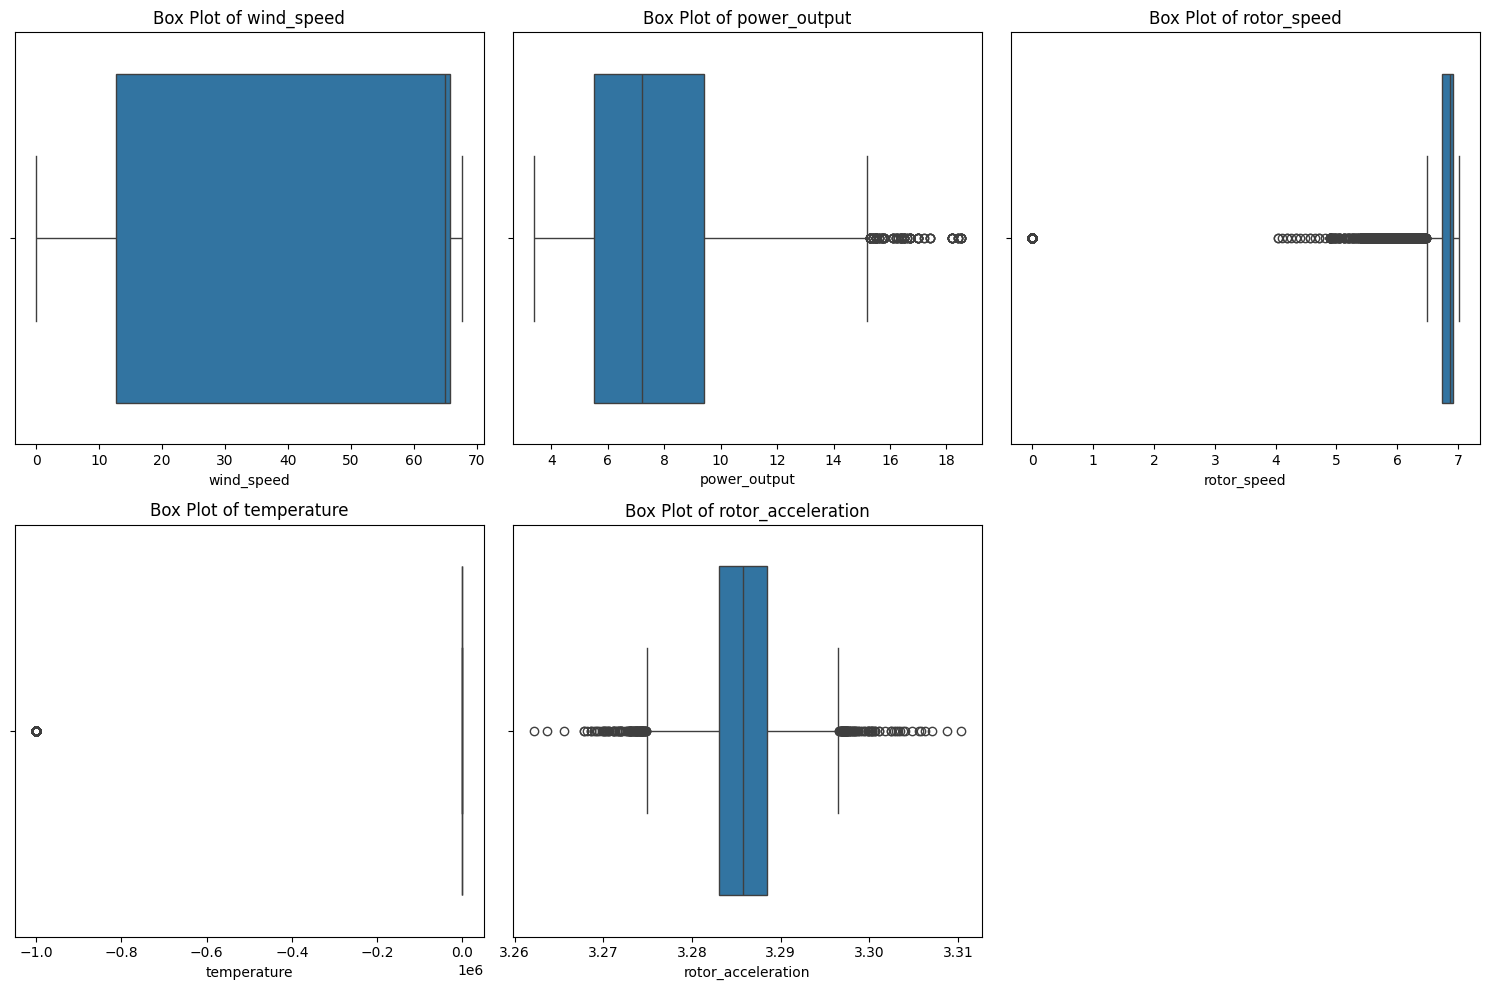

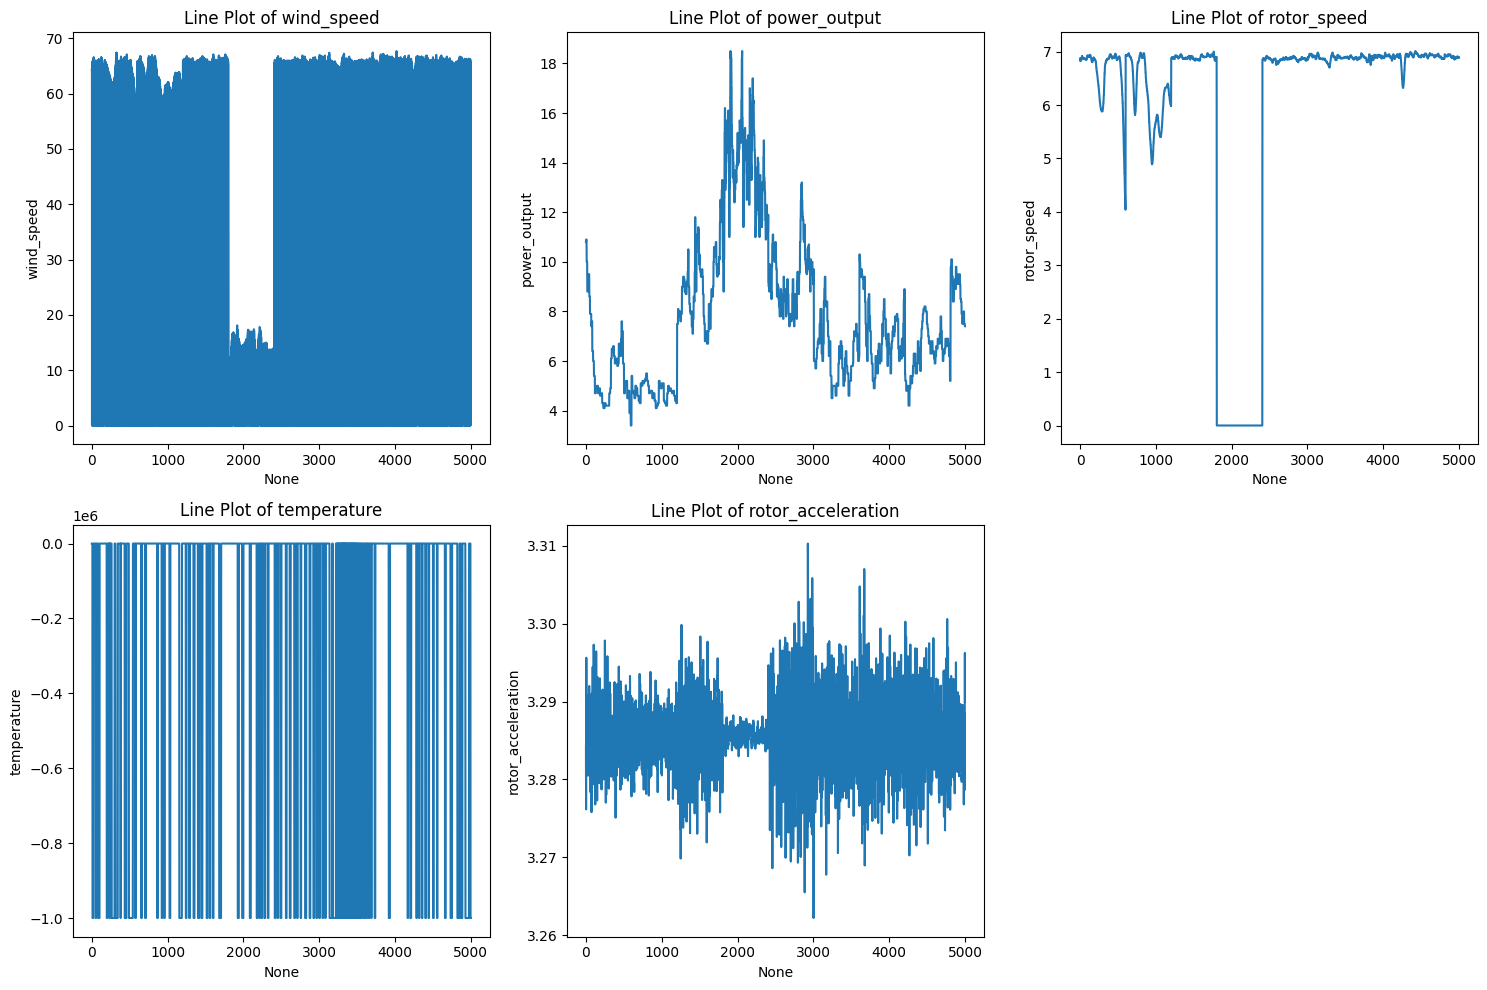

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_eda(combined_df):
    # Plot box plots for each feature to visualize outliers
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(target_signals, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(x=combined_df[col])
        plt.title(f'Box Plot of {col}')
    plt.tight_layout()
    plt.show()

    # Plot line plots for each feature to observe trends over time
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(target_signals, 1):
        plt.subplot(2, 3, i)
        sns.lineplot(x=combined_df.index, y=combined_df[col])
        plt.title(f'Line Plot of {col}')
    plt.tight_layout()
    plt.show()

    # Plot distribution plots for each feature
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(target_signals, 1):
        plt.subplot(2, 3, i)
        sns.histplot(combined_df[col], kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(combined_df[target_signals].corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()


target_signals = ["wind_speed", "power_output", "rotor_speed", "temperature", "rotor_acceleration"]

df1 = pd.read_csv("../datasets/aerodynamic_imbalance.csv")
print("DataFrame shape:", df1.shape)

df = df1.copy().reset_index().iloc[:5000]
# df = df1.iloc[::500].copy()

print("Sample DataFrame shape:", df.shape)

plot_eda(df)


#### Model training

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d-%m-%Y')

# Create labels based on the date
df['aerodynamic_imbalance'] = df['timestamp'].apply(lambda x: 1 if x.date() >= pd.to_datetime('2022-12-08').date() else 0)

# Define the target signals
target_signals = ["wind_speed", "power_output", "rotor_speed", "temperature", "rotor_acceleration"]

# Normalize the target signals
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[target_signals])
y = df["aerodynamic_imbalance"].values.astype(np.float32)

# Create sequences for LSTM input
def create_sequences(data, labels, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        targets.append(labels[i + window_size])
    return np.array(sequences), np.array(targets)

SEQ_LEN = 20
X_seq, y_seq = create_sequences(X_scaled, y, SEQ_LEN)

# Train/val/test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define LSTM Autoencoder
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, input_dim, batch_first=True)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        _, (h, _) = self.encoder(x)  # h: [1, batch, hidden_dim]
        h_repeat = h.repeat(seq_len, 1, 1).permute(1, 0, 2)  # [batch, seq_len, hidden_dim]
        decoded, _ = self.decoder(h_repeat)
        return decoded

# Define CNN+LSTM Model
class CNNLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.lstm = nn.LSTM(input_size=32, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # batch, features, seq_len
        x = self.cnn(x)  # batch, channels, seq_len/2
        x = x.permute(0, 2, 1)  # batch, seq_len/2, channels
        _, (h, _) = self.lstm(x)
        return torch.sigmoid(self.fc(h[-1]))

# Initialize models
input_dim = X_train.shape[2]
hidden_dim = 64

autoencoder = LSTMAutoencoder(input_dim=input_dim, hidden_dim=hidden_dim)
model = CNNLSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim)

# Set loss and optimizer
criterion = nn.MSELoss()
loss_fn = nn.BCELoss()
optimizer_ae = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training function for Autoencoder
def train_autoencoder(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for xb, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, xb)  # Use xb as target for autoencoder
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for xb, _ in val_loader:
                outputs = model(xb)
                loss = criterion(outputs, xb)  # Use xb as target for autoencoder
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

# Training function for CNN+LSTM
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb).squeeze()
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for xb, yb in val_loader:
                outputs = model(xb).squeeze()
                loss = criterion(outputs, yb)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

# Train LSTM Autoencoder
print("Training LSTM Autoencoder...")
train_losses_ae, val_losses_ae = train_autoencoder(autoencoder, train_loader, val_loader, criterion, optimizer_ae, num_epochs=10)

# Train CNN+LSTM Model
print("Training CNN+LSTM Model...")
train_losses, val_losses = train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10)


#### Model evaluation

In [ ]:

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate models
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for xb, yb in test_loader:
            outputs = model(xb).squeeze()
            loss = criterion(outputs, yb)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.4f}')

# Evaluate LSTM Autoencoder
print("Evaluating LSTM Autoencoder...")
evaluate_model(autoencoder, test_loader, criterion)

# Evaluate CNN+LSTM Model
print("Evaluating CNN+LSTM Model...")
evaluate_model(model, test_loader, loss_fn)

# Save models
torch.save(autoencoder.state_dict(), 'lstm_autoencoder_aerodynamic_imbalance.pth')
torch.save(model.state_dict(), 'cnn_lstm_model_aerodynamic_imbalance.pth')
print("Models saved to lstm_autoencoder_aerodynamic_imbalance.pth and cnn_lstm_model_aerodynamic_imbalance.pth")
